<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 4 / SPRINT 2 / NOTE 2*

# 📝 Assignment

---


# Distributed_Representation

## Code

캐글의 [SMS Spam dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset) 에 사전 학습된 Word2Vec 임베딩 벡터를 적용하여 분류해봅시다.<br/>
세션 노트에 있었던 단어 임베딩 벡터를 평균내어 분류하는 방법을 적용해봅시다.

In [ ]:
!pip install gensim --upgrade

     |████████████████████████████████| 23.9MB 124kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import gensim

gensim.__version__

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


'4.0.1'

In [ ]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer

### 1) 데이터 전처리
    
- 데이터셋을 데이터프레임으로 읽어옵니다 `encoding = 'latin-1'` 을 사용합니다.
- 필요없는 열(column)을 삭제합니다.
- LabelEncoder를 사용하여 label 전처리를 해줍니다. 

In [ ]:
from google.colab import files

file = files.upload()

Saving spam.csv to spam.csv


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

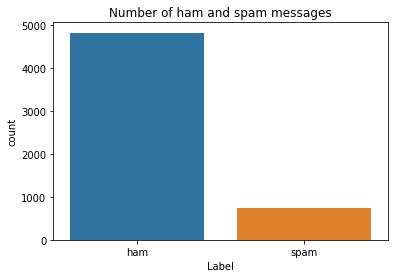

In [ ]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [ ]:
X = df.v2.astype('str')
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

### 2) 텍스트 분류를 수행해주세요.

- 데이터셋 split시 test_size의 비율은 15%로, `random_state = 42` 로 설정합니다. 
- Tokenizer의 `num_words = 1000` 으로 설정합니다.
- pad_sequence의 `maxlen=150` 으로 설정합니다.
- 학습 시, 파라미터는 `batch_size=64, epochs=10, validation_split=0.2` 로 설정합니다.
- evaluate 했을 때의 loss와 accuarcy를 [loss, acc] 형태로 입력해주세요. Ex) [0.4321, 0.8765]

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15, random_state=42)

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [ ]:
vocab_size = len(tok.word_index) + 1
print(vocab_size)

8210


In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))

print(np.shape(embedding_matrix))

(8210, 300)


In [ ]:
def get_vector(word):
    """
    해당 word가 word2vec에 있는 단어일 경우 임베딩 벡터를 반환
    """
    if word in wv:
        return wv[word]
    else:
        return None
 
for word, i in tok.word_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(GlobalAveragePooling1D()) # 모든 단어 벡터의 평균을 구한다.
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(sequences_matrix, Y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
60/60 [==============================] - 1s 10ms/step - loss: 0.6707 - acc: 0.8643 - val_loss: 0.6509 - val_acc: 0.8660
Epoch 2/10
60/60 [==============================] - 0s 8ms/step - loss: 0.6352 - acc: 0.8648 - val_loss: 0.6175 - val_acc: 0.8660
Epoch 3/10
60/60 [==============================] - 0s 8ms/step - loss: 0.6043 - acc: 0.8648 - val_loss: 0.5886 - val_acc: 0.8660
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.5778 - acc: 0.8648 - val_loss: 0.5633 - val_acc: 0.8660
Epoch 5/10
60/60 [==============================] - 0s 8ms/step - loss: 0.5550 - acc: 0.8648 - val_loss: 0.5419 - val_acc: 0.8660
Epoch 6/10
60/60 [==============================] - 0s 8ms/step - loss: 0.5353 - acc: 0.8648 - val_loss: 0.5234 - val_acc: 0.8660
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.5182 - acc: 0.8648 - val_loss: 0.5071 - val_acc: 0.8660
Epoch 8/10
60/60 [==============================] - 0s 7ms/step - loss: 0.5035 - acc: 0.8

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 0s 4ms/step - loss: 0.4697 - acc: 0.8708


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.470
  Accuracy: 0.871
